In [75]:
from statsforecast import StatsForecast
from statsforecast.models import (
    AutoARIMA,
    HoltWinters,
    CrostonClassic as Croston,
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
    MSTL
)
import pandas as pd
import sys
sys.path.append('/Users/victor/code/Arizona3000/metro_seoul/metro_app/ml_logic')
from preprocess import preprocess_lstm, general_preprocessing, model_data_preprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


# Imports

In [76]:
df = pd.read_csv('/Users/victor/code/Arizona3000/metro_seoul/raw_data/crowd2020-2023.csv')


/var/folders/hk/msc7vpvd23n4fn3ktyxcpm2w0000gn/T/ipykernel_56048/1780909122.py:1: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



In [77]:
df = general_preprocessing(df)
df = model_data_preprocessing(df)


/Users/victor/code/Arizona3000/metro_seoul/metro_app/ml_logic/preprocess.py:62: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/victor/code/Arizona3000/metro_seoul/metro_app/ml_logic/preprocess.py:63: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [78]:
df.reset_index(inplace=True)


In [79]:
station_charlotte = [['Dongjak (Seoul National Cemetery)', 4],
 ['Gangnam', 2],
 ['Gireum', 4],
 ['Guro Digital Complex', 2],
 ['Gwanghwamun(Sejong Center for the Performing Arts)', 5],
 ['Hongik Univ.', 2],
 ['Itaewon', 6],
 ['Jamsilsaenae', 2],
 ['Mok-dong', 5],
 ['Nokbeon', 3],
 ['Seongsu', 2],
 ['Seoul Station', 1],
 ['Seoul Station', 4],
 ['World Cup Stadium(Seongsan)', 6],
 ['Yeonsinnae', 3],
 ['Yeonsinnae', 6],
 ['Yeouido', 5]]


In [80]:
df = df.groupby(['datetime', 'station_name', 'station_number', 'line'])['value'].sum().reset_index()


# StatsForecast

In [ ]:
models = [
    AutoARIMA(season_length=24),
    HoltWinters(),
    Croston(),
    SeasonalNaive(season_length=24),
    HistoricAverage(),
    DOT(season_length=24)
]


In [58]:
df_station = df[(df['station_name'] == 'Gireum'.strip()) & (df['line'] == int(4))]

df_model = df_station[['station_name', 'datetime', 'value']]
df_model.rename(columns={'station_name':'unique_id', 'datetime':'ds', 'value':'y'}, inplace=True)


#split data test train
train_size = int(len(df_model) * 0.8)
train, test = df_model.iloc[:train_size, :], df_model.iloc[train_size:, :]

y_train = train[['y']]
X_train = train.drop(columns='y')

y_test = test[['y']]
X_test = test.drop(columns='y')

models = [MSTL(
    season_length=[24, 24 * 7, 24 * 7 * 2], # seasonalities of the time series  ##Ajouter 24*7*365,25
    trend_forecaster=AutoARIMA()
)]

sf = StatsForecast(
    models=models,
    df=train,
    freq='H',
    n_jobs=-1,
    )

forecast = sf.forecast(df = train, h = 24)


/var/folders/hk/msc7vpvd23n4fn3ktyxcpm2w0000gn/T/ipykernel_56048/3163793235.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [59]:
test


,unique_id,ds,y
6781677,Gireum,2022-10-18 15:00:00,2017
6781950,Gireum,2022-10-18 16:00:00,2614
6782223,Gireum,2022-10-18 17:00:00,3333
6782496,Gireum,2022-10-18 18:00:00,4850
6782769,Gireum,2022-10-18 19:00:00,3579
...,...,...,...
8450779,Gireum,2023-06-30 20:00:00,1906
8451052,Gireum,2023-06-30 21:00:00,1807
8451325,Gireum,2023-06-30 22:00:00,1745
8451598,Gireum,2023-06-30 23:00:00,1239


In [60]:
to_plot = forecast.merge(test, on='ds', how='left')


<Axes: xlabel='ds', ylabel='y'>

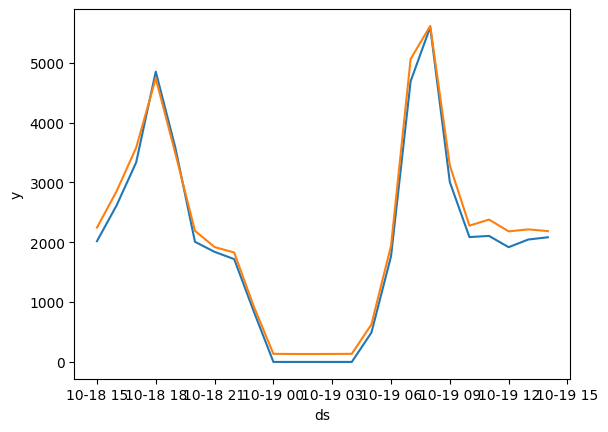

In [67]:
sns.lineplot(to_plot, x='ds', y='y')
sns.lineplot(to_plot, x='ds', y='MSTL')


In [48]:
# Instantiate StatsForecast class as sf
sf = StatsForecast(
    df=train,
    models=models,
    freq='H',
    n_jobs=-1,
)


In [49]:
forecasts_df = sf.forecast(h=24*7, level=[90])


/var/folders/hk/msc7vpvd23n4fn3ktyxcpm2w0000gn/T/ipykernel_56048/2658692471.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/hk/msc7vpvd23n4fn3ktyxcpm2w0000gn/T/ipykernel_56048/2658692471.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/hk/msc7vpvd23n4fn3ktyxcpm2w0000gn/T/ipykernel_56048/2658692471.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/hk/msc7vpvd23n4fn3ktyxcpm2w0000gn/T/ipyker

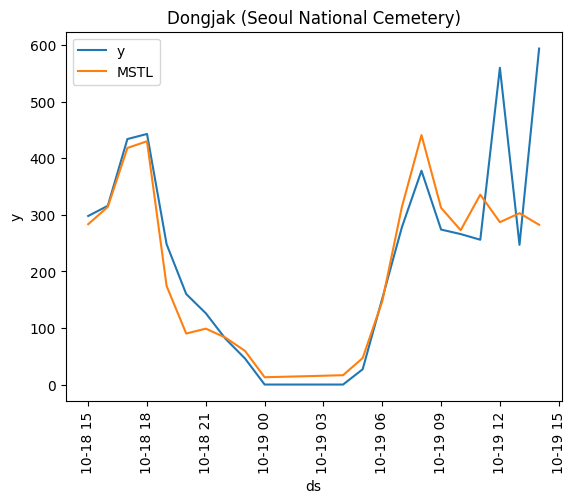

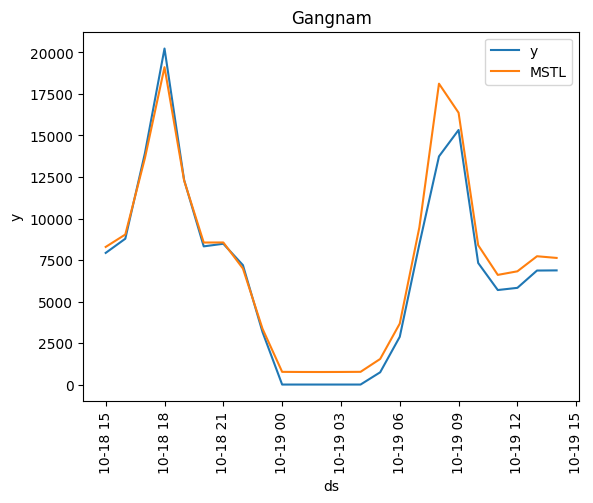

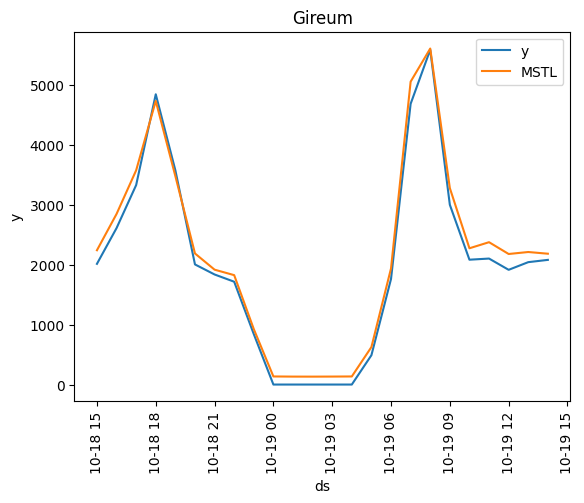

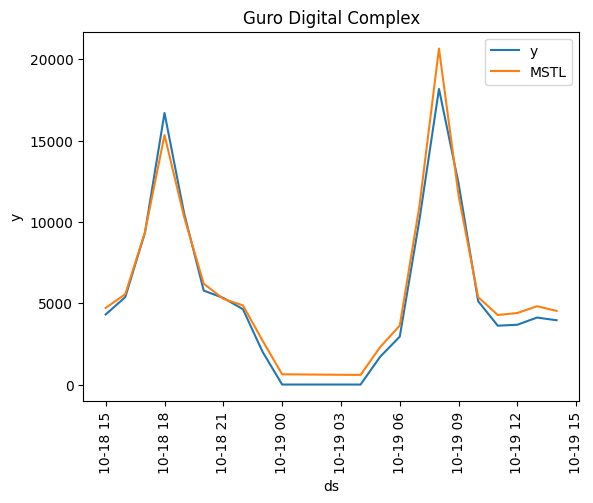

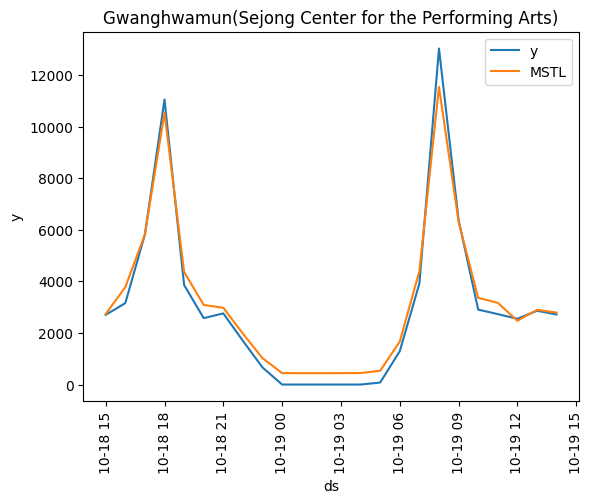

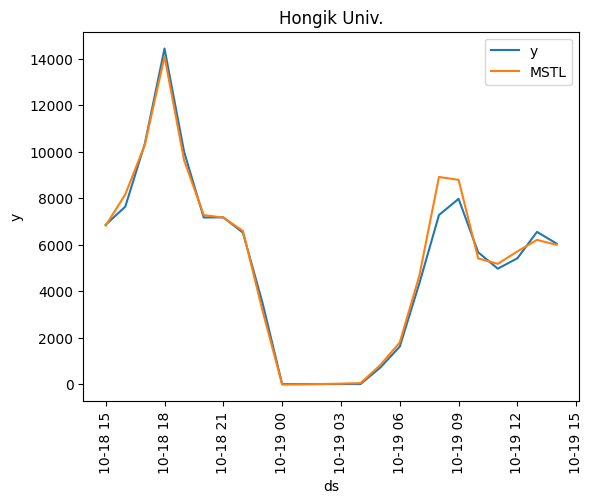

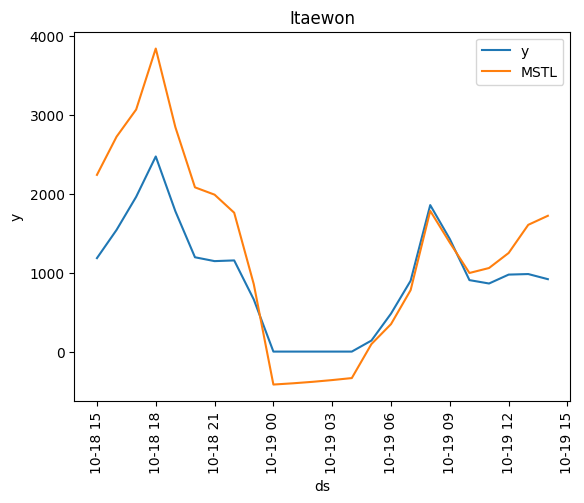

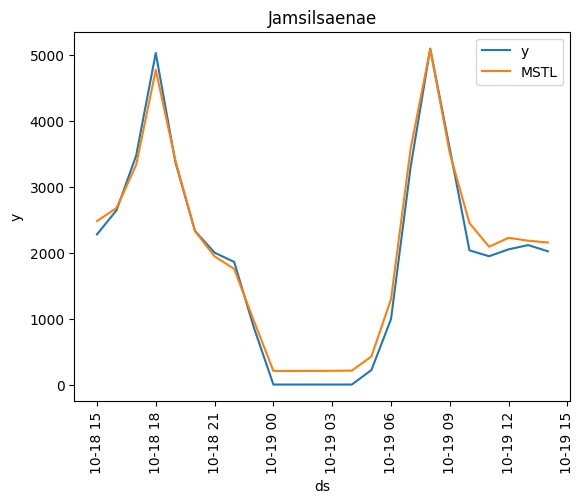

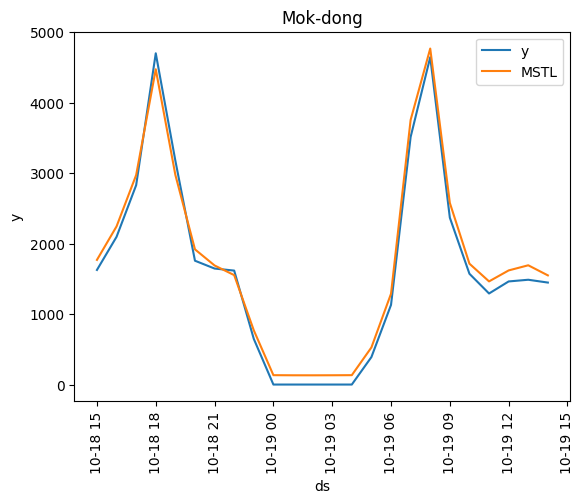

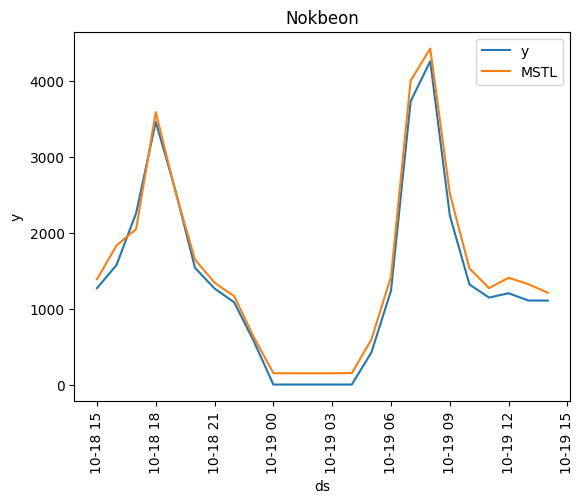

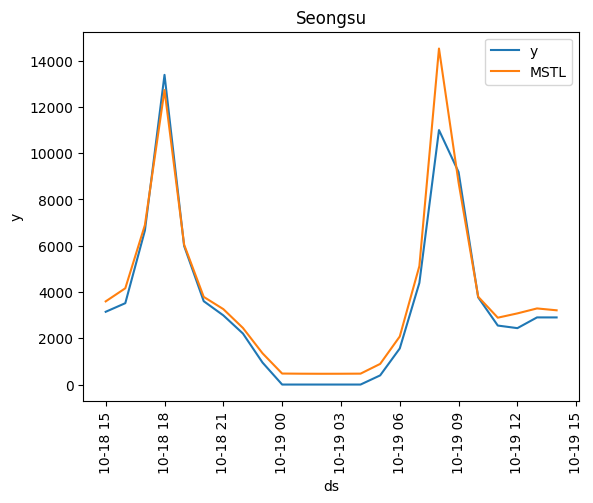

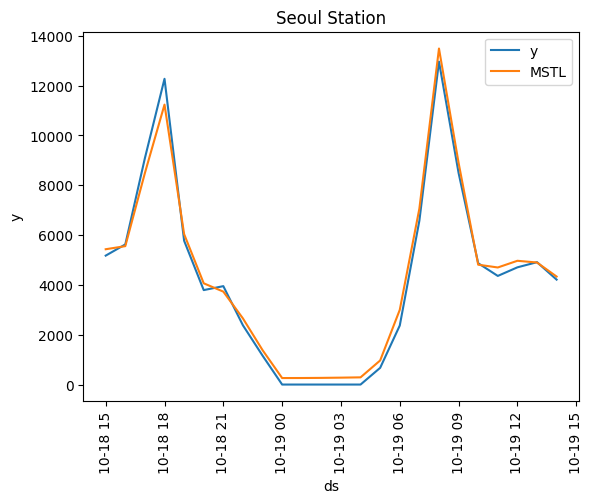

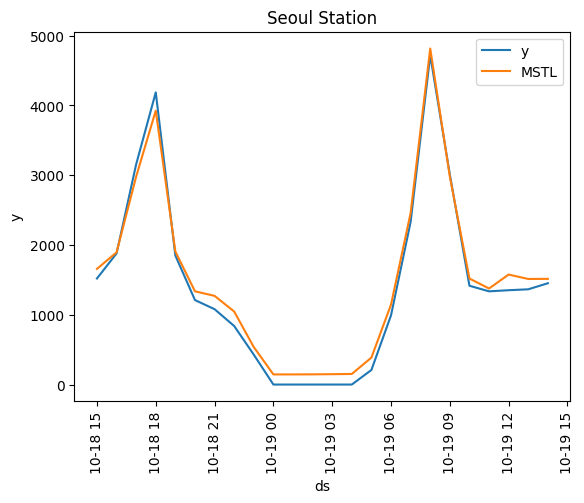

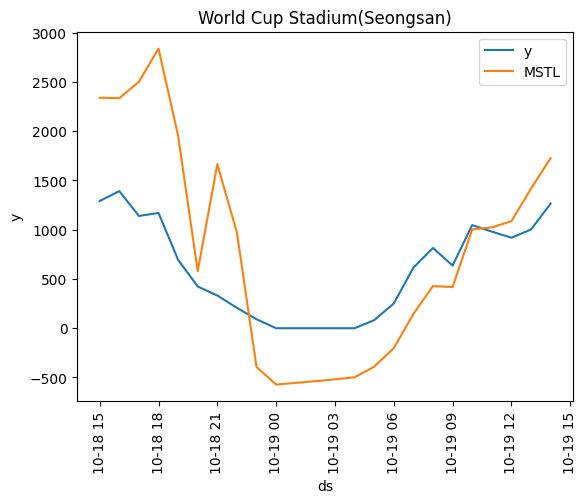

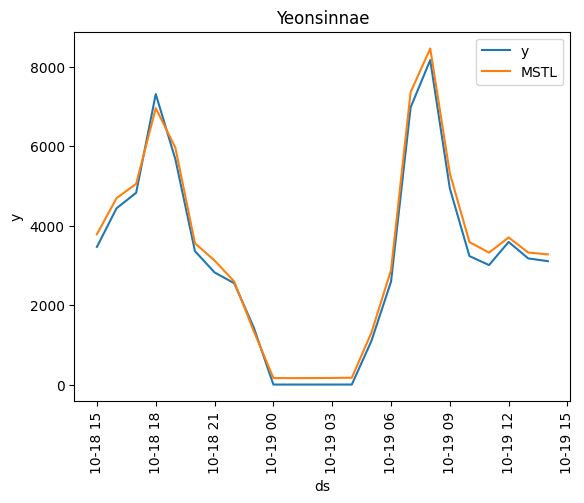

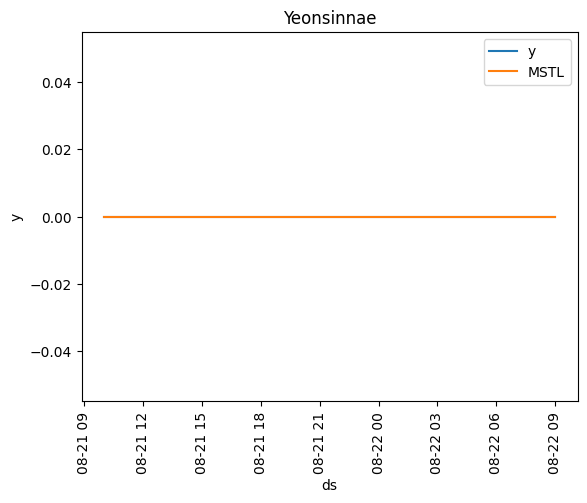

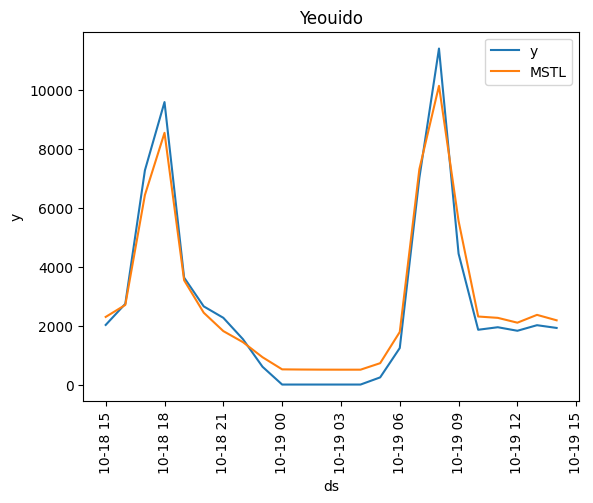

In [83]:
for station, station_line in station_charlotte:

    df_station = df[(df['station_name'] == station.strip()) & (df['line'] == int(station_line))]

    df_model = df_station[['station_name', 'datetime', 'value']]
    df_model.rename(columns={'station_name':'unique_id', 'datetime':'ds', 'value':'y'}, inplace=True)


    #split data test train
    train_size = int(len(df_model) * 0.8)
    train, test = df_model.iloc[:train_size, :], df_model.iloc[train_size:, :]

    y_train = train[['y']]
    X_train = train.drop(columns='y')

    y_test = test[['y']]
    X_test = test.drop(columns='y')

    models = [MSTL(
        season_length=[24, 24 * 7, 24 * 7 * 2], # seasonalities of the time series  ##Ajouter 24*7*365,25
        trend_forecaster=AutoARIMA()
    )]

    sf = StatsForecast(
        models=models,
        df=train,
        freq='H',
        n_jobs=-1,
        )

    forecast = sf.forecast(df = train, h = 24)

    to_plot = forecast.merge(test, on='ds', how='left')

    fig, ax = plt.subplots()
    sns.lineplot(to_plot, x='ds', y='y', ax=ax, label='y')
    sns.lineplot(to_plot, x='ds', y='MSTL', ax=ax, label='MSTL')
    plt.title(station)
    plt.legend()
    plt.xticks(rotation=90)

    station_number = df_station.station_number.unique()[0]
    pickle.dump(sf, open(f'../models_test/MSTL{station_number}.pkl', 'wb'))


In [34]:
sf.predict(h=len(test), X_df=X_test)


/Users/victor/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/statsforecast/arima.py:1557: UserWarning: xreg not required by this model, ignoring the provided regressors
  warnings.warn(


,ds,MSTL
unique_id,,
Dongjak (Seoul National Cemetery),2022-10-18 15:00:00,266.970764
Dongjak (Seoul National Cemetery),2022-10-18 16:00:00,303.822510
Dongjak (Seoul National Cemetery),2022-10-18 17:00:00,406.805359
Dongjak (Seoul National Cemetery),2022-10-18 18:00:00,396.468018
Dongjak (Seoul National Cemetery),2022-10-18 19:00:00,138.827423
...,...,...
Dongjak (Seoul National Cemetery),2023-06-30 20:00:00,30.554430
Dongjak (Seoul National Cemetery),2023-06-30 21:00:00,81.502220
Dongjak (Seoul National Cemetery),2023-06-30 22:00:00,98.594795


In [35]:
y_test


,y
6781647,298
6781920,316
6782193,434
6782466,443
6782739,248
...,...
8450749,230
8451022,168
8451295,134
8451568,75


# Test model from file 

In [89]:
test_model = pickle.load(open('/Users/victor/code/Arizona3000/metro_seoul/models_test/MSTL150.pkl', 'rb'))


In [95]:
df_station = df[(df['station_name'] == 'Seoul Station'.strip()) & (df['line'] == int(1))]

df_model = df_station[['station_name', 'datetime', 'value']]
df_model.rename(columns={'station_name':'unique_id', 'datetime':'ds', 'value':'y'}, inplace=True)


#split data test train
train_size = int(len(df_model) * 0.8)
train, test = df_model.iloc[:train_size, :], df_model.iloc[train_size:, :]


/var/folders/hk/msc7vpvd23n4fn3ktyxcpm2w0000gn/T/ipykernel_56048/3685055662.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [96]:
forecast = test_model.forecast(df = train, h = 24)


In [97]:
forecast


,ds,MSTL
unique_id,,
Seoul Station,2022-10-18 15:00:00,5431.443359
Seoul Station,2022-10-18 16:00:00,5555.485352
Seoul Station,2022-10-18 17:00:00,8491.355469
Seoul Station,2022-10-18 18:00:00,11237.166992
Seoul Station,2022-10-18 19:00:00,6038.020996
Seoul Station,2022-10-18 20:00:00,4063.614014
Seoul Station,2022-10-18 21:00:00,3730.004639
Seoul Station,2022-10-18 22:00:00,2653.873535
Seoul Station,2022-10-18 23:00:00,1382.447998


In [94]:
df[df['station_number']=='150']


,datetime,station_name,station_number,line,value
6090601,2022-07-05 01:00:00,Seoul Station,150,1,0
6090874,2022-07-05 02:00:00,Seoul Station,150,1,0
6091147,2022-07-05 03:00:00,Seoul Station,150,1,0
6091420,2022-07-05 04:00:00,Seoul Station,150,1,0
6091693,2022-07-05 05:00:00,Seoul Station,150,1,619
...,...,...,...,...,...
6482159,2022-09-02 20:00:00,Seoul Station,150,1,4657
6482433,2022-09-02 21:00:00,Seoul Station,150,1,4551
6482707,2022-09-02 22:00:00,Seoul Station,150,1,3049
6482981,2022-09-02 23:00:00,Seoul Station,150,1,1688


# Put all models done to google cloud 

In [117]:
sys.path.append('/Users/victor/code/Arizona3000/metro_seoul/gcp')
from setup import upload, cred
import os


In [121]:
for filename in os.listdir('/Users/victor/code/Arizona3000/metro_seoul/models_test'):

    print(upload(f'/Users/victor/code/Arizona3000/metro_seoul/models_test/{filename}', file_name=f'models/MSTL/{filename}', path_to_json_key='/Users/victor/gcp/metro-seoul-86af79318438.json'))


uploaded file!
uploaded file!
uploaded file!
uploaded file!
uploaded file!
uploaded file!
uploaded file!
uploaded file!
uploaded file!
uploaded file!
uploaded file!
uploaded file!
uploaded file!
uploaded file!
uploaded file!
uploaded file!
uploaded file!


In [120]:
cred('/Users/victor/gcp/metro-seoul-86af79318438.json')
